<h2>Word2Vec with Namuwiki articles </h2>
In this notebook I will compare the result of similar words of given keyword from two models. The two models are different with respect to the training data-training data are from two different domains. One from namuwiki article and the other one from the following github link.

(https://github.com/Kyubyong/wordvectors)

In [1]:
# 필요한 라이브러리 설치
"""
!pip install beautifulsoup4
!pip install requests
!pip install wordcloud
!pip install matplotlib
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import requests
from bs4 import BeautifulSoup
import re

<h1>과제 코드</h1>

나무위키 도메인의 이름, 주소

1.로스앤젤레스 - 나무위키
https://namu.wiki/w/%EB%A1%9C%EC%8A%A4%EC%95%A4%EC%A0%A4%EB%A0%88%EC%8A%A4  


2.에미넴 - 나무위키
https://namu.wiki/w/%EC%97%90%EB%AF%B8%EB%84%B4

In [2]:
#!pip install konlpy
from konlpy.tag import Okt
from collections import Counter

In [3]:
# 불필요한 키워드 필터링
# file downloaded from https://gist.github.com/spikeekips/40eea22ef4a89f629abd87eed535ac6a
ko_stopwords_path = "stopwords-ko.txt"

with open(ko_stopwords_path, encoding='utf-8') as f:
    stopwords= f.readlines()
stopwords = [x.strip() for x in stopwords]

# add my stopwords
my_stopwords = ['통해','또한','있다','대해', '한다','있다','했다','이후','그리고','대한','거나','사실','아예','서로',
                '있는','적이','것도','하고','상당히','없는','있지만','있는데','당시','자신의','볼','있으며', '실제로','것을','아닌','인해','그냥','등이', '아니라',
                '이전', '역사','문단','이전','주로','것이','된다','있고', '사이','경우','정도',
                '상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장', '많은','많이','역시','위해','다시','그의','등의',
                '줄거리', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물','나는','나의','내가','이는','것이다',
                '이름', '년월','문서의','같은','특히','하는','문서를의','문단을의','것은','펼치기','접기','것은','자세한','내용은','부분을','참조하십시오','참고하십시오']
for stopword in my_stopwords:
    stopwords.append(stopword)

In [4]:
print(stopwords)

['가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공동으로', '과', '과연', '관계가 있다', '관계없이', '관련이 있다', '관하여', '관한', '관해서는', '구', '구체적으로', '구토하다', '그', '그들', '그때', '그래', '그래도', '그래서', '그러나', '그러니', '그러니까', '그러면', '그러므로', '그러한즉', '그런 까닭에', '그런데', '그런즉', '그럼', '그럼에도 불구하고', '그렇게 함으로써', '그렇지', '그렇지 않다면', '그렇지 않으면', '그렇지만', '그렇지않으면', '그리고', '그리하여', '그만이다', '그에 따르는', '그위에', '그저', '그중에서', '그치지 않다', '근거로', '근거하여', '기대여', '기점으로', '기준으로', '기타', '까닭으로', '까악', '까지', '까지 미치다', '까지도', '꽈당', '끙끙', '끼익', '나', '나머지는', '남들', '남짓', '너', '너희', '너희들', '네', '넷', '년', '논하지 않다', '놀라다', '누가 알겠는가', '누구', '다른', '다른 방면으로', '다만', '다섯', '다소', '다수', '다시 말하자면', '다시말하면', '다음', '다음에', '다음으로', '단지', '답다', '당신', '당장', '대로 하다', '대하면', '대하여', '대해 말하자면', '대해서', '댕그', '더구나', '더군다나', '더라도', '더불어', '더욱더', '더욱이는', '도달하다', '도착하다', '동시에', '동안', '된바에야', '된이상', '두번째로', '둘', '둥둥', '뒤따라', '뒤이어'

In [5]:
def wordcloud_for_articles(url, wordcloud_title):
    # 페이지 요청 및 파싱
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # 본문 태그의 내용만 크롤링
    paragraphs = soup.find_all("div", class_="wiki-heading-content")
    content = ' '.join([para.get_text() for para in paragraphs])
    # Remove punctuation from content
    content = re.sub(r'[^\w\s]', '', content) 
    byte_content = bytearray(content, 'utf-8') # memory error 방지

    # '개요' 단어 이후의 모든 'div wiki-link-internal' 태그 내의 링크 추출
    start=soup.find(string="개요")
    internal_link = start.find_all_next("a",class_="wiki-link-internal")
    links = [a['href'] for a in internal_link[:100]]

    # 추출한 링크 내용 크롤링
    for url in links:
        response = requests.get(f'https://namu.wiki/'+url)
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all("div",class_="wiki-heading-content")
        content = ' '.join([para.get_text() for para in paragraphs])
        content = re.sub(r'[^\w\s]', '', content) # Remove punctuation from content
        # This code prevents memory error
        tmp = bytearray(content, 'utf-8')
        byte_content.extend(tmp)

    # decode
    filtered_result = byte_content.decode()
    
    # konlpy의 형태소 분석기로 명사 단위의 키워드를 추출
    okt = Okt()
    nouns = okt.nouns(filtered_result)
    #길이가 1인 단어 제거
    filtered_nouns= ' '.join([x for x in nouns if len(x) > 1])
    # stopword 필터링
    filtered_nouns = ' '.join([word for word in filtered_nouns.split() if word not in stopwords])
    
    # 어떤 단어가 몇 번 나오는지 알기 위해 추가
    counter = Counter(filtered_nouns.split())
    
    # 한글 폰트 경로 설정 (나눔고딕 폰트 사용)
    font_path = 'NanumSquareOTF_acB.otf'

    # 타원 모양의 word cloud
    mask = np.array(Image.open('oval_shape.jpg'))
    # Word Cloud 생성
    wordcloud = WordCloud(font_path=font_path, width=1000, height=500, background_color='white', mask=mask).generate(filtered_nouns)
    
    # Word Cloud 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(wordcloud_title)
    plt.show()

    # 링크 출력
    print("Extracted Links:")
    for link in links:
        print(link)

    return counter, filtered_nouns.split()

<h2>Eminem</h2>

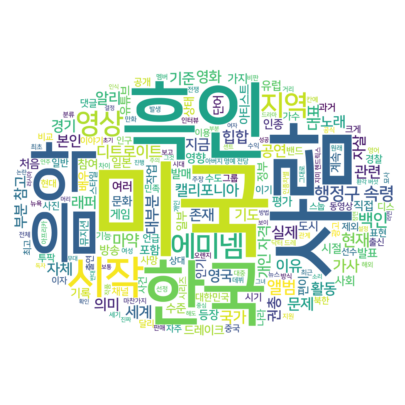

Extracted Links:
/w/%EB%AF%B8%EA%B5%AD
/w/%EB%94%94%ED%8A%B8%EB%A1%9C%EC%9D%B4%ED%8A%B8
/w/%EB%9E%98%ED%8D%BC
/w/%EB%B0%B0%EC%9A%B0
/w/%ED%9D%91%EC%9D%B8
/w/%ED%9E%99%ED%95%A9
/w/%EB%B0%B1%EC%9D%B8
/w/%EB%A1%9C%ED%81%B0%EB%A1%A4%20%EB%AA%85%EC%98%88%EC%9D%98%20%EC%A0%84%EB%8B%B9
/w/EGOT
/w/Mathers
/w/%EC%96%BC%ED%84%B0%20%EC%97%90%EA%B3%A0
/w/%EB%8C%80%EC%A4%91%EC%9D%8C%EC%95%85
/w/%ED%9E%99%ED%95%A9
/w/%ED%9E%99%ED%95%A9
/w/%EA%B2%8C%EC%8A%A4%ED%8A%B8
/w/%EB%9D%BC%ED%82%B4
/w/%EB%B9%85%20%EB%8C%80%EB%94%94%20%EC%BC%80%EC%9D%B8
/w/%EC%95%84%EC%9D%B4%EC%8A%A4%20%ED%81%90%EB%B8%8C
/w/Andre%203000
/w/Redman
/w/LL%20Cool%20J
/w/Treach
/w/Run%20DMC
/w/%EB%9D%BC%ED%82%B4
/w/%EB%B9%85%20%EB%8C%80%EB%94%94%20%EC%BC%80%EC%9D%B8
/w/%EC%BF%A8%20%EC%A7%80%20%EB%9E%A9
/w/BBC
/w/%EB%B0%A5%20%EB%94%9C%EB%9F%B0
/w/%EC%9B%94%EC%8A%A4%ED%8A%B8%EB%A6%AC%ED%8A%B8%20%EC%A0%80%EB%84%90
/w/%EC%97%98%ED%8A%BC%20%EC%A1%B4
/w/%EC%A7%80%EB%AF%B8%20%ED%97%A8%EB%93%9C%EB%A6%AD%EC%8A%A4
/w/%EB%AF%B9%20%EC%9E%AC%EA%

In [6]:
eminem_counter, eminem_list = wordcloud_for_articles("https://namu.wiki/w/%EC%97%90%EB%AF%B8%EB%84%B4", "eminem.pdf")

In [7]:
print(eminem_counter)
print(eminem_list)

Counter({'미국': 1552, '흑인': 1347, '앨범': 892, '사람': 872, '음악': 701, '힙합': 656, '마약': 651, '한국': 623, '디트로이트': 581, '백인': 533, '지역': 523, '에미넴': 509, '영상': 499, '래퍼': 475, '시작': 461, '문제': 432, '부분': 418, '발매': 417, '인종': 392, '자살': 374, '속령': 370, '권총': 369, '세계': 364, '행정구': 362, '현재': 354, '도시': 343, '관련': 338, '참고': 334, '공연': 332, '개인': 332, '국가': 331, '영화': 329, '활동': 323, '사회': 323, '가사': 315, '알리': 306, '대표': 298, '대부분': 296, '이유': 285, '인구': 284, '실제': 278, '캘리포니아': 276, '자격': 270, '평가': 266, '최고': 262, '배우': 256, '기준': 250, '아프리카': 249, '문화': 248, '자체': 243, '기도': 243, '드레이크': 238, '본인': 237, '노래': 237, '의미': 232, '사건': 230, '그룹': 228, '수상': 225, '아티스트': 224, '일본': 222, '수준': 221, '영향': 221, '영국': 221, '범죄': 220, '광고': 218, '정부': 216, '지금': 214, '기록': 212, '지미': 209, '싱글': 208, '방송': 207, '경기': 206, '일부': 205, '켄드릭': 205, '존재': 205, '가지': 203, '디스': 202, '여러': 194, '시절': 192, '참여': 191, '채널': 188, '빌보드': 187, '유럽': 186, '포함': 185, '단어': 185, '드레': 184, '뮤지션': 184, '유튜브': 182, '인

In [18]:
from gensim.models import Word2Vec
eminem_model = Word2Vec([eminem_list], size=100, window=5, min_count=1, sg=1)

# find most similar words
similar_words_album = eminem_model.wv.most_similar("앨범", topn=5)
print("similar words to 앨범: ", similar_words_album)
similar_words = eminem_model.wv.most_similar("음악", topn=5)
print("similar words to 음악: ", similar_words)

similar_words = eminem_model.wv.most_similar("에미넴", topn=5)
print("similar words to 에미넴: ", similar_words)

similar_words = eminem_model.wv.most_similar("드레", topn=5)
print("similar words to 드레: ", similar_words)

similar_words = eminem_model.wv.most_similar("미국", topn=5)
print("similar words to 미국: ", similar_words)

similar_words = eminem_model.wv.most_similar("셰이디", topn=5)
print("similar words to 셰이디: ", similar_words)

similar_words = eminem_model.wv.most_similar("라임", topn=5)
print("similar words to 라임: ", similar_words)

similar_words = eminem_model.wv.most_similar("백인", topn=5)
print("similar words to 백인: ", similar_words)

similar_words = eminem_model.wv.most_similar("흑인", topn=5)
print("similar words to 흑인: ", similar_words)

similar_words = eminem_model.wv.most_similar("트랙", topn=5)
print("similar words to 트랙: ", similar_words)

similar words to 앨범:  [('발매', 0.9921581745147705), ('트랙', 0.9902864098548889), ('에미넴', 0.9890544414520264), ('가사', 0.9851975440979004), ('최고', 0.9850373864173889)]
similar words to 음악:  [('에미넴', 0.9736366868019104), ('디스', 0.9732924103736877), ('게이', 0.9722670316696167), ('래퍼', 0.9720175266265869), ('작업', 0.9704010486602783)]
similar words to 에미넴:  [('래퍼', 0.9960187077522278), ('디스', 0.9950130581855774), ('헤일리', 0.9939066171646118), ('가사', 0.993752658367157), ('트랙', 0.9934704899787903)]
similar words to 드레:  [('에미넴', 0.9872272610664368), ('디스', 0.9859911799430847), ('래퍼', 0.9843916296958923), ('참여', 0.9838201403617859), ('트랙', 0.9829434156417847)]
similar words to 미국:  [('국가', 0.9981671571731567), ('세계', 0.9979637861251831), ('현재', 0.9967485666275024), ('나라', 0.9958208799362183), ('도시', 0.9954006671905518)]
similar words to 셰이디:  [('에미넴', 0.9691038131713867), ('래퍼', 0.9686997532844543), ('트랙', 0.9678321480751038), ('앨범', 0.9651822447776794), ('피처링', 0.964645504951477)]
similar words to

<h2>LA</h2>

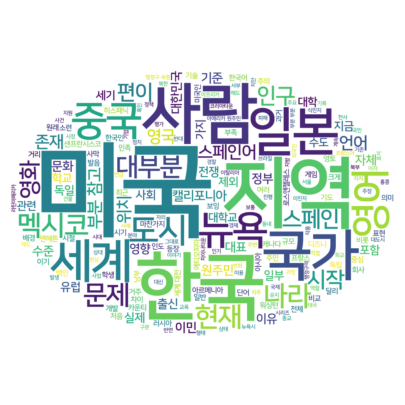

Extracted Links:
/w/%EC%BA%98%EB%A6%AC%ED%8F%AC%EB%8B%88%EC%95%84
/w/%EB%AF%B8%EA%B5%AD
/w/%EB%89%B4%EC%9A%95%EC%8B%9C
/w/LA%20%EB%8B%A4%EC%A0%80%EC%8A%A4
/w/%ED%95%A0%EB%A6%AC%EC%9A%B0%EB%93%9C
/w/%EC%84%B8%EA%B3%84%EB%8F%84%EC%8B%9C
/w/%EC%A7%80%EC%A4%91%ED%95%B4%EC%84%B1%20%EA%B8%B0%ED%9B%84
/w/%EB%89%B4%EC%9A%95
/w/%EC%9B%8C%EC%8B%B1%ED%84%B4%20D.C.
/w/%EC%83%8C%ED%94%84%EB%9E%80%EC%8B%9C%EC%8A%A4%EC%BD%94
/w/%EC%8A%A4%ED%8E%98%EC%9D%B8%EC%96%B4
/w/%EC%B2%9C%EC%82%AC
/w/%EC%A0%95%EA%B4%80%EC%82%AC
/w/%EC%98%81%EC%96%B4
/w/the
/w/%EC%8A%A4%ED%8E%98%EC%9D%B8%20%EC%A0%9C%EA%B5%AD
/w/%EC%A3%BC%EA%B0%9D%EC%A0%84%EB%8F%84
/w/%EC%97%94%EC%A0%A4
/w/%EB%9D%BC%ED%8B%B4%20%EC%95%84%EB%A9%94%EB%A6%AC%EC%B9%B4
/w/%EA%B0%80%EC%B0%A8
/w/%EB%82%98%EC%84%B1
/w/%EB%91%90%EC%9D%8C%EB%B2%95%EC%B9%99
/w/%EC%A4%91%EA%B5%AD
/w/%ED%95%9C%EA%B5%AD%20%ED%95%9C%EC%9E%90%EC%9D%8C
/w/%EB%82%98%EC%84%B1%EC%97%90%20%EA%B0%80%EB%A9%B4
/w/%EC%8A%A4%ED%8E%98%EC%9D%B8%20%EC%A0%9C%EA%B5%AD
/w/1781%EB%85%84
/w/%EC%95%

In [11]:
la_counter, la_list = wordcloud_for_articles("https://namu.wiki/w/%EB%A1%9C%EC%8A%A4%EC%95%A4%EC%A0%A4%EB%A0%88%EC%8A%A4", "la.pdf")

In [12]:
print(la_counter)

Counter({'미국': 3323, '지역': 1618, '한국': 1451, '영어': 1268, '뉴욕': 1165, '국가': 1147, '세계': 1115, '일본': 1077, '사람': 1007, '영화': 979, '인구': 868, '도시': 848, '멕시코': 837, '스페인': 836, '중국': 810, '스페인어': 712, '원주민': 665, '부분': 658, '전쟁': 620, '영국': 606, '문제': 590, '참고': 582, '현재': 551, '나라': 540, '문화': 526, '언어': 524, '대부분': 504, '캘리포니아': 493, '시작': 492, '정부': 488, '독일': 473, '디즈니': 458, '이민': 452, '세기': 449, '대학': 441, '기후': 434, '편이': 434, '대학교': 429, '보잉': 421, '경제': 417, '할리우드': 411, '사회': 404, '위치': 397, '수준': 396, '존재': 389, '대표': 379, '유럽': 377, '기준': 376, '발음': 375, '학교': 374, '프랑스': 374, '제국': 370, '출신': 370, '공화국': 361, '아메리카': 359, '대한민국': 355, '관련': 351, '정치': 348, '일부': 347, '영향': 344, '사막': 342, '캐나다': 336, '로스앤젤레스': 333, '백인': 328, '히스패닉': 324, '자체': 324, '가지': 320, '남부': 319, '실제': 315, '주의': 315, '관계': 309, '이유': 305, '감독': 305, '포함': 301, '민주당': 301, '미국인': 296, '시리즈': 293, '지금': 291, '제외': 291, '소련': 290, '수도': 288, '러시아': 285, '샌프란시스코': 279, '워싱턴': 276, '아시아': 276, '단어': 275, 

In [20]:
la_model = Word2Vec([la_list], size=100, window=5, min_count=1, sg=1)

# LA
# 선택한 단어 2개 : 미국, 지역
# find most similar words
similar_words_usa = la_model.wv.most_similar("미국",topn=5)
print("similar words to 미국: ", similar_words_usa)
similar_words_region = la_model.wv.most_similar("지역",topn=5)
print("similar words to 지역: ", similar_words_region)

similar_words_region = la_model.wv.most_similar("한국",topn=5)
print("similar words to 한국: ", similar_words_region)

similar_words_region = la_model.wv.most_similar("로스앤젤레스",topn=5)
print("similar words to 로스앤젤레스: ", similar_words_region)

similar_words_region = la_model.wv.most_similar("문제",topn=5)
print("similar words to 문제: ", similar_words_region)

similar words to 미국:  [('도시', 0.9994357824325562), ('캘리포니아', 0.999259352684021), ('지역', 0.9990960359573364), ('인구', 0.9990023374557495), ('샌프란시스코', 0.9990021586418152)]
similar words to 지역:  [('캘리포니아', 0.9993088245391846), ('도시', 0.9992004632949829), ('샌프란시스코', 0.9991987943649292), ('미국', 0.9990960955619812), ('위치', 0.9990418553352356)]
similar words to 한국:  [('샌프란시스코', 0.9864932298660278), ('이민자', 0.9863953590393066), ('정부', 0.9863893985748291), ('주민', 0.986164927482605), ('인구', 0.9860509037971497)]
similar words to 로스앤젤레스:  [('도시', 0.9987578392028809), ('인구', 0.9986127614974976), ('배경', 0.9985603094100952), ('미국', 0.9985508918762207), ('샌프란시스코', 0.9981628656387329)]
similar words to 문제:  [('캘리포니아', 0.9987000226974487), ('도시', 0.9984737634658813), ('위치', 0.9984506368637085), ('미국', 0.9984067678451538), ('인구', 0.9982300996780396)]


<h3>사전학습된 모델</h3>

from https://github.com/Kyubyong/wordvectors (korean)

In [21]:
import gensim
ko_model = gensim.models.Word2Vec.load('ko.bin') # ko.bin 파일의 경로
print("For Eminem...")
a=ko_model.wv.most_similar("앨범")
print("Similar words to 앨범: ", a)
a=ko_model.wv.most_similar("음악")
print("Similar words to 음악: ", a)
print("\nFor LA...")
a=ko_model.wv.most_similar("미국")
print("Similar words to 미국: ",a)
a=ko_model.wv.most_similar("지역")
print("Similar words to 지역: ", a)

For Eminem...
Similar words to 앨범:  [('음반', 0.8888179659843445), ('싱글', 0.812667191028595), ('곡', 0.6709103584289551), ('곡인', 0.6646201610565186), ('히트곡', 0.6572105884552002), ('신곡', 0.6358738541603088), ('대표곡', 0.6250746846199036), ('밴드', 0.6148888468742371), ('연주곡', 0.6039382815361023), ('발매', 0.6023983955383301)]
Similar words to 음악:  [('재즈', 0.7056578993797302), ('성악', 0.6756843328475952), ('음악인', 0.6618658900260925), ('기악', 0.655972957611084), ('댄스', 0.6555739641189575), ('연극', 0.6458802223205566), ('무용', 0.6436582207679749), ('로큰롤', 0.6425950527191162), ('모던', 0.6397438049316406), ('실내악', 0.6394776701927185)]

For LA...
Similar words to 미국:  [('영국', 0.8002187013626099), ('캐나다', 0.7176880240440369), ('독일', 0.6284154057502747), ('오스트레일리아', 0.6244829893112183), ('대한민국', 0.5982763767242432), ('프랑스', 0.5751551389694214), ('워싱턴', 0.573469877243042), ('뉴욕', 0.5671893358230591), ('컬럼비아', 0.5550029277801514), ('쿠바', 0.5517946481704712)]
Similar words to 지역:  [('지방', 0.6961730718612671), (